# Aula 08 - Aprendendo a Ranquear - Exercícios

In [1]:
import pandas as pd
import numpy as np
import random

### Importar base de dados

In [2]:
# import wget
# !python3 -m wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
# !tar -xvzf ml-20m-compact.tar.gz

In [3]:
movies = pd.read_csv('./dataset/movies_sample.csv')
ratings = pd.read_csv('./dataset/ratings_sample.csv')
df = ratings[['userId', 'movieId', 'rating']]
df = df.merge(movies[['movieId', 'title']])
df

/tmp/ipykernel_36030/3176036202.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings = pd.read_csv('./dataset/ratings_sample.csv')


,userId,movieId,rating,title
0,11,7481,5.0,Enemy Mine (1985)
1,11,1046,4.5,Beautiful Thing (1996)
2,11,616,4.0,"Aristocats, The (1970)"
3,11,3535,2.0,American Psycho (2000)
4,11,5669,5.0,Bowling for Columbine (2002)
...,...,...,...,...
190616,138493,288,5.0,Natural Born Killers (1994)
190617,138493,1748,5.0,Dark City (1998)
190618,138493,616,4.0,"Aristocats, The (1970)"
190619,138493,1597,4.5,Conspiracy Theory (1997)


### Mapeamento de ids

In [4]:
map_users = {user: idx for idx, user in enumerate(df.userId.unique())}
map_items = {item: idx for idx, item in enumerate(df.movieId.unique())}
df['userId'] = df['userId'].map(map_users)
df['movieId'] = df['movieId'].map(map_items)
map_title = {}

for _, row in df.iterrows():
    map_title[row.movieId] = row.title


### Divisão da base em treino e teste

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=2)

### Nesta aula, você podera escolher entre implementar o primeiro, o segundo ou ambos os exercícios abaixo.

***Exercício 01:*** Comparação entre um algoritmo pair-wise e point-wise:
- Utilizando o BPR implementado em aula, gere uma lista de 10 recomendações para um determinado usuário da base.
- Calcule a precisão média dessas recomendações usando como ground-truth o conjunto de teste. 
- Utilize o algoritmo MatrixFactorization (SVD otimizado) de predição de notas para prever as notas dos itens que aquele usuário não avaliou ainda. 
- Ordene inversamente esses itens pela nota predita, e recomende os 10 primeiros filmes.
- Calcule a precisão média dessas recomendações e compare o resultado com o resultado obtido pelo BPR. 

In [6]:
# TODO

***Exercicio 02:*** Na aula vimos a implementação do método draw() do algoritmo BPR tradicional. Para um dado usuário, este método retorna aleatoriamente um item que ele viu (**item i**) e um outro item que ele não conhece (**item j**). O algoritmo assume que o item visto é preferível ao que ele não viu, e isso é usado para maximizar a diferença entre os scores desses itens (veja a variável **x_uij** da implementação). 

Um problema dessa abordagem é que os itens não vistos são necessariamente encarados como menos relevante pelo algoritmo, o que nem sempre acontece pois pode ser que o usuário não tenha interagido com aquele item pois não o conhece, mas que poderia gostar. Um outro problema é quando ambos os itens i e j foram vistos pelo usuário, o que numa estratégia com feedback exclusivamente implícito o BPR não consegue diferenciar qual item é preferível ao usuário. 

Você consegue pensar numa estratégia aperfeiçoada para o método draw()? Exemplos:
- Se tivermos acesso aos metadados, podemos construir um perfil para o usuário de modo que o método draw() vai retornar itens j que estão mais distantes desse perfil.
- Se dois itens i e j foram vistos, use os metadados (ou as notas, caso use feedback explícito) para decidir qual deles deve ser o i e qual deve ser o j. 
- Etc.

Implemente pelo menos uma estratégia de aperfeiçoamento do BPR, e compare com a versão original. 

### Construção de um sistema de recomendação baseado em conteudo, para o caso pelo menos um dos itens escolhido não tiver sido visto

In [7]:
movies['movieId'] = movies['movieId'].map(map_items)

movies_genres = movies.drop('genres', axis=1).join(movies.genres.str.split('|', expand=True)
             .stack().reset_index(drop=True, level=1).rename('genre'))
movies_genres.dropna(inplace=True)
movies_genres['movieId'] = movies_genres.movieId.astype(int)
movies_genres.head()

,movieId,title,genre
0,49,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Crime
0,49,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Drama
1,61,Dangerous Minds (1995),Drama
2,125,Across the Sea of Time (1995),Documentary
2,125,Across the Sea of Time (1995),IMAX


Salvando a amostra de teste e de treino em um arquivo .dat para o Case Recommender usar

In [8]:
movies_genres[['movieId', 'genre']].to_csv('items_genres.dat', index=False, sep='\t', header=False)
train.to_csv('train.dat', index=False, header=False, sep='\t')
test.to_csv('test.dat', index=False, header=False, sep='\t')

In [ ]:
class SimpleContentPredictor:
    def __init__(self):
        self.user_profiles_ = {}
        self.item_genres_map_ = {}

    def fit(self, train_df, item_df):
        print("Treinando")
        self.item_genres_map_ = item_df.groupby('movieId')['genre'].apply(set).to_dict()

        train_gostou = train_df[train_df['rating'] >= 4]
        user_genres = pd.merge(train_gostou, item_df, on='movieId')
        profiles = user_genres.groupby('userId')['genre'].value_counts().unstack(fill_value=0)
        self.user_profiles_ = profiles.to_dict('index')

    def predict(self, userId, movieId):
        user_profile = self.user_profiles_.get(userId, {})
        item_genres = self.item_genres_map_.get(movieId, set())

        if not user_profile or not item_genres:
            return train['rating'].mean() 

        intersection_score = 0
        for genre in item_genres:
            intersection_score += user_profile.get(genre, 0)
        
        score = intersection_score / sum(user_profile.values()) if sum(user_profile.values()) > 0 else 0
        return 1 + 4 * score 

knn_content = SimpleContentPredictor()
knn_content.fit(train, movies_genres)

Treinando
Consultor treinado e pronto!


### Preparação visando a performance 

In [16]:
def get_item_ids(df, userId):
    if userId not in df['userId'].values:
        return []
    return (df.loc[(df.userId==userId),'movieId'].tolist())


observed = dict()
all_users = df['userId'].unique().tolist()
known_items = train['movieId'].unique().tolist()

for u in all_users:
    observed[u] = get_item_ids(train, u)

ratings_lookup = train.set_index(['userId', 'movieId'])['rating'].to_dict()

In [ ]:
def improved_draw(userId, knn_model):
    while True:
        item_A, item_B = random.sample(known_items, 2)
        
        visto_A = item_A in observed[userId]
        visto_B = item_B in observed[userId]

        # CASO 1: Ambos os itens foram vistos pelo utilizador. Usar as notas reais.
        if visto_A and visto_B:
            rating_A = ratings_lookup.get((userId, item_A))
            rating_B = ratings_lookup.get((userId, item_B))
            
            if rating_A > rating_B: return item_A, item_B
            elif rating_B > rating_A: return item_B, item_A
            else: continue # Se as notas forem iguais, faz um novo sorteio

        # CASO 2: Apenas o item A foi visto, usar previsão em B
        elif visto_A and not visto_B:
            nota_real_A = ratings_lookup.get((userId, item_A))
            nota_prevista_B = knn_model.predict(userId, item_B)
            
            if nota_real_A > nota_prevista_B: return item_A, item_B
            else: return item_B, item_A

        # CASO 3: Apenas o item B foi visto, mesma logica do CASO 2
        elif not visto_A and visto_B:
            nota_prevista_A = knn_model.predict(userId, item_A)
            nota_real_B = ratings_lookup.get((userId, item_B))
            
            if nota_real_B > nota_prevista_A: return item_B, item_A
            else: return item_A, item_B
        
        # CASO 4: Prever nota para ambos
        else:
            nota_prevista_A = knn_model.predict(userId, item_A)
            nota_prevista_B = knn_model.predict(userId, item_B)
            
            if nota_prevista_B > nota_prevista_A: return item_B, item_A
            else: return item_A, item_B

--- A testar draw_melhorado() para o Utilizador 1 ---
Item 'i' (preferido) escolhido: 335 (Nota: Não Visto (Nota Prevista))
Item 'j' (menos preferido) escolhido: 127 (Nota: Não Visto (Nota Prevista))

Isto confirma que a função está a usar a melhor informação disponível para criar o par.


### Treinamento do modelo

In [23]:
def train_bprmf(train, n_factors, lr=0.05, reg=0.02, miter=30):    
    n_users = df['userId'].max()+1
    n_items = df['movieId'].max()+1    
    item_bias = np.zeros(n_items)
    p = np.random.normal(0, 0.1, (n_users, n_factors))
    q = np.random.normal(0, 0.1, (n_items, n_factors))
    
    error = []
    for t in range(miter):
        print('Iter #', t)
        sq_error = 0
        random_users = random.choices(train['userId'].unique(), k=len(train))
        for u in random_users:
            i, j = improved_draw(u, knn_content)
            x_uij = item_bias[i] - item_bias[j] + (np.dot(p[u], q[i]) - np.dot(p[u], q[j]))
            sq_error += x_uij
            
            eps = 1 / (1 + np.exp(x_uij))

            item_bias[i] += lr * (eps - reg * item_bias[i])
            item_bias[j] += lr * (-eps - reg * item_bias[j])            

            # Adjust the factors
            u_f = p[u]
            i_f = q[i]
            j_f = q[j]

            # Compute and apply factor updates
            p[u] += lr * ((i_f - j_f) * eps - reg * u_f)
            q[i] += lr * (u_f * eps - reg * i_f)
            q[j] += lr * (-u_f * eps - reg * j_f)
            
        error.append(sq_error/len(random_users))
            
    return item_bias, p, q, error

In [24]:
b, p, q, error = train_bprmf(train, 4)

Iter # 0
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18
Iter # 19
Iter # 20
Iter # 21
Iter # 22
Iter # 23
Iter # 24
Iter # 25
Iter # 26
Iter # 27
Iter # 28
Iter # 29


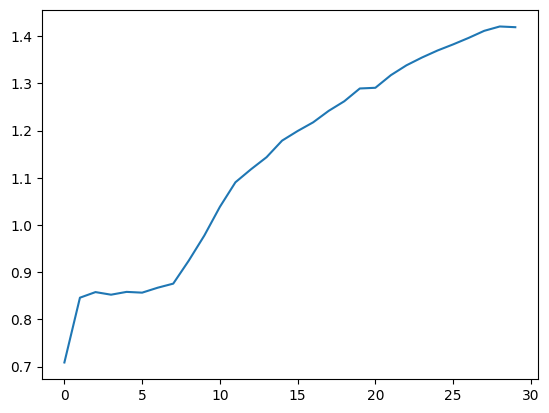

In [25]:
import matplotlib.pyplot as plt

plt.plot(error)
plt.show()

Comparando com o erro do algoritmo simples visto em sala de aula, esse apresenta métricas melhorasdas (erro caiu quase pela metade), isso que o algorimo de previsão de notas foi simples, poderia melhorar muito mais